# Gravimetrey : Derive

Correction of the instrumental derive at the base station

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('data/derive.csv')

In [3]:
def f(x):
    t = x.split(':')
    s = ''
    for e in t:
        if len(e) == 1:
            s+= '0'
        s += e
    return s

In [4]:
df['GRAV'] = df['GRAV'].map(lambda x: float(x.replace(',', '.')))
df['DEC.TIME+DATE'] = df['DEC.TIME+DATE'].map(lambda x: float(x.replace(',', '.')))
df['TIME'] = df['TIME'].map(f)

In [5]:
df

,Unnamed: 0,LINE,STATION,ALT.,GRAV,SD,TILTX,TILTY,TEMP,TIDE,DUR,REJ,TIME,DEC.TIME+DATE,TERRAIN,DATE,time diff,type
0,0,0,0,"35,9373",4508.427,"0,019",-4,"-1,3","-0,73","0,02",60,11,083209,45505.35509,0,02/09/24,NaN,"base 1, lundi matin"
1,1,0,0,"34,960700000000003",4508.430,"0,010999999999999999","-4,0999999999999996","-2,4","-0,74","0,025000000000000001",60,8,084159,45505.36191,0,02/09/24,0:09:50,NaN
2,2,0,0,"36,669699999999999",4508.432,"0,010999999999999999",-1,"-2,5","-0,74","0,033000000000000002",60,10,085611,45505.37175,0,02/09/24,0:14:12,tilt
3,3,0,0,"36,669699999999999",4508.433,"0,0099999999999999999998","-0,1","-2,6","-0,74","0,034000000000000002",60,0,085721,45505.37256,0,02/09/24,0:01:10,NaN
4,4,0,0,"36,425600000000003",4508.432,"0,0089999999999999993","0,6","-2,8","-0,74","0,034000000000000002",60,0,085826,45505.37331,0,02/09/24,0:01:05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,314,0,0,"30,566199999999998",4508.763,"0,0080000000000000002",0,"-1,8","-0,64",0,60,0,104108,45508.44452,0,05/09/24,0:01:10,NaN
315,315,0,0,"30,810300000000002",4508.763,"0,0060000000000000001","0,1","-1,9","-0,64",0,60,0,104213,45508.44527,0,05/09/24,0:01:05,NaN
316,316,0,0,"30,810300000000002",4508.763,"0,0060000000000000001","0,2","-1,9","-0,65","0,001",60,0,104318,45508.44602,0,05/09/24,0:01:05,NaN
317,317,0,0,"30,810300000000002",4508.763,"0,014","0,3",-2,"-0,65","0,001",60,12,104423,45508.44677,0,05/09/24,0:01:05,NaN


In [6]:
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format="%d/%m/%y %H%M%S")

In [7]:
df['UT'] = pd.to_datetime(df['DATETIME']).astype(int)/ 10**9

In [8]:
model = LinearRegression()

x = df[['UT']]
y = df['GRAV']

# Train the model
model.fit(x, y)

# Evaluate the model
r2_score = model.score(x, y)
print(f"R-squared value: {r2_score}")

R-squared value: 0.9974275860877059


In [9]:
model = LinearRegression()

x = df[['DEC.TIME+DATE']] # 2 different times from UT or DEC.TIME
y = df['GRAV']

# Train the model
model.fit(x, y)

# Evaluate the model
r2_score = model.score(x, y)
print(f"R-squared value: {r2_score}")
coef = model.coef_[0]

R-squared value: 0.9974263059601833


In [10]:
df['GRAVCORR'] = df['GRAV'] - coef*(df['DEC.TIME+DATE'] - df['DEC.TIME+DATE'].iloc[0])

In [11]:
print('Correction max :', np.max(df['GRAVCORR']) - np.min(df['GRAVCORR']))

Correction max : 0.032192893052524596


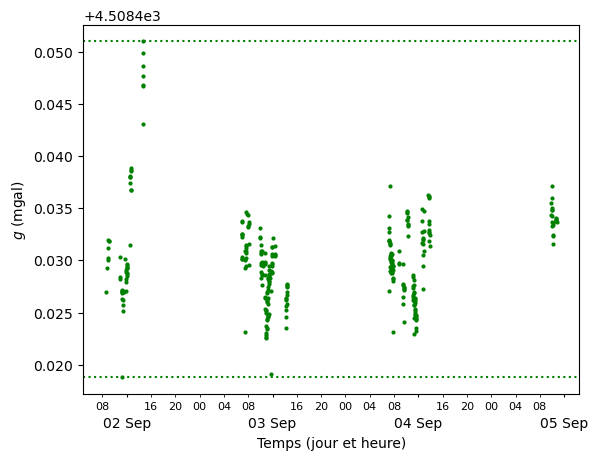

In [12]:
fig = plt.figure()

plt.plot(df['DATETIME'], df['GRAVCORR'], 'go', ms=2, label='Mesure')
plt.axhline(np.max(df['GRAVCORR']), c='g', linestyle=':', label='Extremum des mesures')
plt.axhline(np.min(df['GRAVCORR']), c='g', linestyle=':')
#plt.axhline(np.mean(df['GRAVCORR']), c='k')
plt.ylabel('$g$ (mgal)')
plt.xlabel('Temps (jour et heure)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

ax.xaxis.set_minor_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

ax.tick_params(which="minor", axis="x", labelsize=8)
ax.tick_params(which="major", axis="x", pad=14, size=2)
#plt.legend()

plt.savefig('figures/gravi_corr_valeurs.png')

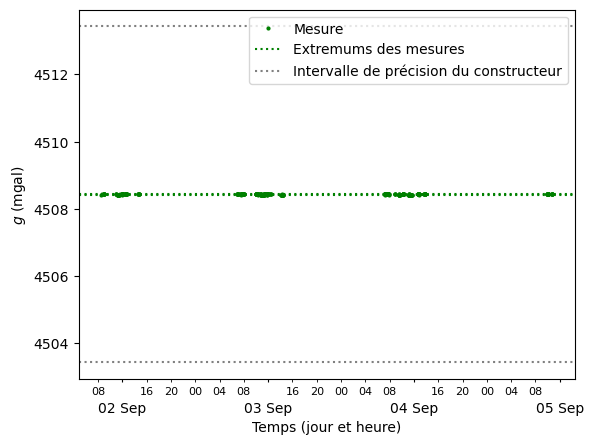

In [13]:
fig = plt.figure()

plt.plot(df['DATETIME'], df['GRAVCORR'], 'go', ms=2, label='Mesure')
plt.axhline(np.max(df['GRAVCORR']), c='g', linestyle=':', label='Extremums des mesures')
plt.axhline(np.min(df['GRAVCORR']), c='g', linestyle=':')
#plt.axhline(np.mean(df['GRAVCORR']), c='k')
plt.axhline(np.mean(df['GRAVCORR']) + 5, c='grey', linestyle=':', label='Intervalle de précision du constructeur')
plt.axhline(np.mean(df['GRAVCORR']) - 5, c='grey', linestyle=':')
plt.ylabel('$g$ (mgal)')
plt.xlabel('Temps (jour et heure)')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

ax.xaxis.set_minor_locator(mdates.HourLocator(np.arange(0, 24, 4)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

ax.tick_params(which="minor", axis="x", labelsize=8)
ax.tick_params(which="major", axis="x", pad=14, size=2)
plt.legend()

plt.savefig('figures/gravi_corr_precision.png')

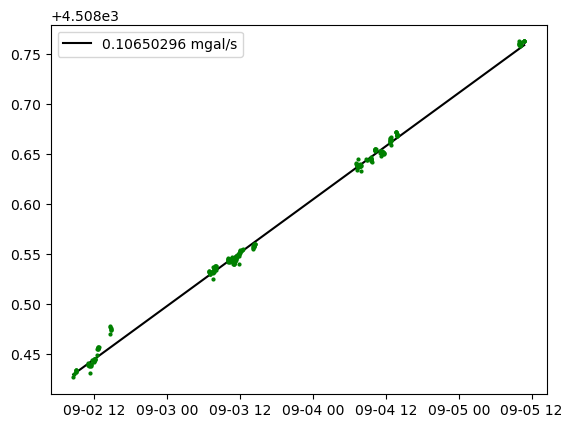

In [14]:
plt.plot(df['DATETIME'], model.predict(x), 'k-', label=f'{coef:.8f} mgal/s')
plt.plot(df['DATETIME'], df['GRAV'], 'go', ms=2)
plt.legend()

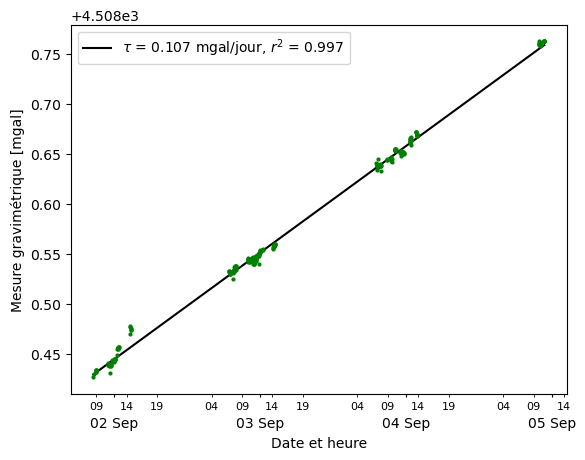

In [15]:
fig = plt.figure()
plt.plot(df['DATETIME'], model.predict(x), 'k-', label=r'$\tau$'f' = {coef:.3f} mgal/jour, 'r'$r^2$'f' = {r2_score:.3f}')
plt.plot(df['DATETIME'], df['GRAV'], 'go', ms=2)
plt.legend()
plt.xlabel('Date et heure')
plt.ylabel('Mesure gravimétrique [mgal]')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

ax.xaxis.set_minor_locator(mdates.HourLocator([4, 9, 14, 19]))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

ax.tick_params(which="major", axis="x", pad=14, size=2)
ax.tick_params(which="minor", axis="x", labelsize=8)
plt.savefig('figures/gravi_derive_4j.png')

R-squared value: 0.8479557586408883
R-squared value: 0.8973973213400604
R-squared value: 0.9005233567636207
R-squared value: 0.4722796980579136


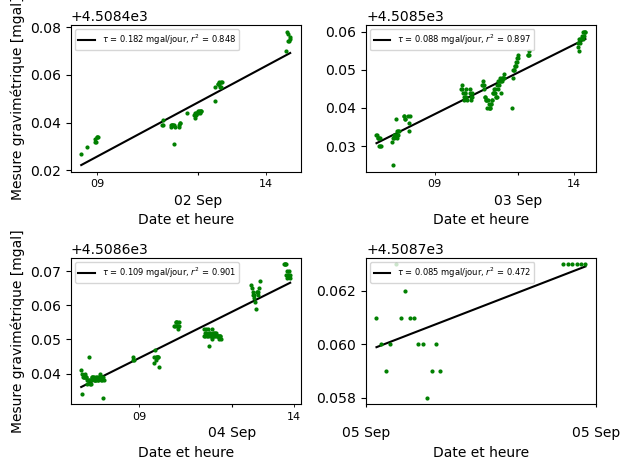

In [16]:
k = 1
for date in df['DATE'].unique():
    subdf = df[df['DATE'] == date]
    
    model = LinearRegression()

    x = subdf[['DEC.TIME+DATE']]
    y = subdf['GRAV']
    
    # Train the model
    model.fit(x, y)
    
    # Evaluate the model
    r2_score = model.score(x, y)
    print(f"R-squared value: {r2_score}")
    coef = model.coef_[0]

    plt.subplot(2, 2, k)

    plt.plot(subdf['DATETIME'], model.predict(x), 'k-', label=r'$\tau$'f' = {coef:.3f} mgal/jour, 'r'$r^2$'f' = {r2_score:.3f}')
    plt.plot(subdf['DATETIME'], subdf['GRAV'], 'go', ms=2)
    plt.legend(fontsize="6", loc="upper left")
    plt.xlabel('Date et heure')
    if k%2==1:
        plt.ylabel('Mesure gravimétrique [mgal]')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    
    ax.xaxis.set_minor_locator(mdates.HourLocator([4, 9, 14, 19]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
    
    ax.tick_params(which="major", axis="x", pad=14, size=2)
    ax.tick_params(which="minor", axis="x", labelsize=8)
    k += 1
plt.tight_layout()
plt.savefig(f'figures/gravi_derive_4j_sub.png')